# Running experiments for our local calibration method

In [1]:
# importing generally used modules
import numpy as np

# for modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory

# data frames and statistics
from scipy import stats
import pandas as pd

# workspace management and counting running time
import os
import time

# graphics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# original directory
path_original = os.getcwd()

# our functions
# both quantile prediction models
from lcv.valid_pred_sets import LinearQuantileRegression
from lcv.valid_pred_sets import GradientBoostingQuantileRegression

# non-conformity scores
from lcv.scores import RegressionScore, QuantileScore

# locart method
from lcv.locart import LocartSplit

# quantile split
from lcv.locart import QuantileSplit

# figure path
images_dir = "figures"

In [11]:
a = np.array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

AttributeError: 'numpy.ndarray' object has no attribute 'diff'

In [3]:
np.diff(a)

array([ 0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0, -1])

In [36]:
np.append(np.where((np.diff(a) != 0))[0], 0)

array([ 2,  7, 12, 16,  0])

In [32]:
np.where((np.diff(a) != 0))[0][-1]

16

In [10]:
np.tile(np.array([1, 0]), 2)

array([1, 0, 1, 0])

In [16]:
pred = np.array([[0.1, 0.5]])

In [13]:
b = np.array([1, 2, 3])

In [15]:
pred[:, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [17]:
scores = np.column_stack((pred[:, 0] - b, b - pred[:, 1]))

In [19]:
np.max(scores, axis = 1)

array([0.5, 1.5, 2.5])

## Simulated datasets
Now we will consider the same simulated datasets generated by Izbicki et.al (2022) to assess our hypothesis testing framework:

In [2]:
# importing simulated datasets module
from simulation import simulation

# shuffling and splitting in train, calibration and test sets
def split(X, y, test_size = 0.4, calibrate = True, random_seed = 1250):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size,
                                                        random_state = random_seed)
    if calibrate:
        X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.3,
                                                             random_state = random_seed)
        return {"X_train":X_train, "X_calib": X_calib, "X_test" : X_test, 
                "y_train" : y_train, "y_calib" : y_calib, "y_test": y_test}
    else:
        return{"X_train":X_train,"X_test" : X_test, 
                "y_train" : y_train,"y_test": y_test}

We will also need to compute conditional and real coverage. For that, we can compute coverage with the following function:

In [11]:
# methods to compute coverage
def real_coverage(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    r_margin = np.zeros((y_mat.shape[0], y_mat.shape[1]))
    for i in range(model_preds.shape[0]):
        r_margin[i, :] = np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1])
        r[i] = np.mean(r_margin[i, :])
    r_margin = r_margin.flatten()
    return [r, r_margin]

def locart_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    r_margin = np.zeros((y_mat.shape[0], y_mat.shape[1]))
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        # marginal
        r_margin[i, :] = locart_model.predict_coverage(new_X, y_mat[i, :], marginal = True)
        # conditional
        r[i] = np.mean(r_margin[i, :]) 
    r_margin = r_margin.flatten()
    return [r, r_margin]

def uniform_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    r_margin = np.zeros((y_mat.shape[0], y_mat.shape[1]))
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        # marginal
        r_margin[i, :] = locart_model.predict_coverage_uniform(new_X, y_mat[i, :], marginal = True)
        # conditional
        r[i] = np.mean(r_margin[i, :])
    r_margin = r_margin.flatten()
    return [r, r_margin]


# methods to compute interval length
def compute_average_interval(predictions):
    return(np.mean(predictions[:, 1] - predictions[:, 0]))

Testing our pruning approach versus other decision trees regarding conditional coverage:

In [12]:
def test_pruning(kind = "homoscedastic", 
           n = 10000,
           d = 20, 
           coef = 2,
           hetero_value = 1, 
           random_seed = 1250,
           sig = 0.05,
           B_x = 3000,
           B_y = 500,
           grid_min_samples = np.array([100, 500, 1000, 1500, 2000]),
           type_score = "regression",
           base_model = RandomForestRegressor,
           split_calib = False,
           **kwargs):
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = False)

    # coverage plot elements
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        # fitting pruning locart
        locart_prune = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_prune.fit(split_icp["X_train"], split_icp["y_train"])
        locart_prune.calib(split_icp["X_test"], split_icp["y_test"])

        # conditional and marginal coverage
        cond_locart_real, marginal_locart_real = locart_coverage(locart_prune, X_test, y_mat)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_cover = np.mean(cond_locart_real)
        locart_ave_marginal_cov = np.mean(marginal_locart_real)
        locart_interval = compute_average_interval(np.array(locart_prune.predict(X_test)))

        # list of locart models 
        coverage_list = [locart_ave_cover]
        dist_list = [locart_ave_dist]
        marg_coverage_list = [locart_ave_marginal_cov]
        int_length_list = [locart_interval]
        methods_names = ["Pruned tree"]

        for min_samples_leaf in grid_min_samples:
            locart = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart.fit(split_icp["X_train"], split_icp["y_train"])
            locart.calib(split_icp["X_test"], split_icp["y_test"], prune_tree = False, min_samples_leaf = min_samples_leaf)
            # computing coverage
            cond_coverage, marginal_coverage = locart_coverage(locart, X_test, y_mat)
            # computing metrics
            dist_list.append(np.mean(np.abs(cond_coverage - (1 - sig))))
            coverage_list.append(np.mean(cond_coverage))
            marg_coverage_list.append(np.mean(marginal_coverage))
            int_length_list.append(compute_average_interval(np.array(locart.predict(X_test))))

            methods_names.append("leafs = " + str(min_samples_leaf))
        
        return pd.DataFrame(data = {"Methods":methods_names,
        "Average conditional coverage":coverage_list, 
        "Average distance":dist_list,
        "Average marginal coverage": marg_coverage_list,
        "Average interval length": int_length_list})

Analysing coverage for different CART versions:

In [13]:
test_pruning()

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.948947,0.009825,0.948947,3.978883
1,leafs = 100,0.965501,0.016923,0.965501,3.795883
2,leafs = 500,0.950441,0.009740,0.950441,3.917545
3,leafs = 1000,0.948925,0.009769,0.948925,3.937696
4,leafs = 1500,0.952021,0.009893,0.952021,3.923629
5,leafs = 2000,0.951192,0.009776,0.951192,3.954809


In [14]:
test_pruning(kind = "heteroscedastic", hetero_value=0.5)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.967543,0.030483,0.967543,5.563479
1,leafs = 100,0.983787,0.034729,0.983787,5.341982
2,leafs = 500,0.974975,0.030923,0.974975,5.439466
3,leafs = 1000,0.971860,0.030501,0.971860,5.494216
4,leafs = 1500,0.967769,0.030479,0.967769,5.469601
5,leafs = 2000,0.961119,0.032091,0.961119,5.771677


We also analyse the efficiency of splitting locart tree:

In [15]:
test_pruning(split_calib = True)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.950320,0.009859,0.950320,4.002628
1,leafs = 100,0.928361,0.022044,0.928361,4.018390
2,leafs = 500,0.948185,0.009877,0.948185,3.973476
3,leafs = 1000,0.951646,0.009825,0.951646,3.956951
4,leafs = 1500,0.948069,0.009816,0.948069,3.962286
5,leafs = 2000,0.950452,0.009755,0.950452,4.008328


In [16]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value=0.5)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.970672,0.030356,0.970672,5.584821
1,leafs = 100,0.984912,0.035577,0.984912,5.473791
2,leafs = 500,0.970193,0.030571,0.970193,5.573654
3,leafs = 1000,0.948784,0.036820,0.948784,5.882360
4,leafs = 1500,0.951207,0.035432,0.951207,5.834823
5,leafs = 2000,0.951506,0.035509,0.951506,5.855645


We will first compare our method to other conformal and non conformal methods using $S(\boldsymbol{x}, y) = |g(\boldsymbol{x}) - y|$ (Regression score) as our non conformity score:

### Regression Score

We will first focus in comparing these methods on homoscedastisc and heteroscedastic Normal data with noise. But firsst, we test our method using few features as below:

In [3]:
# testing locart split method
d = 1
coef = 3
kind = "homoscedastic"
random_seed = 1250
n = 15000

sim_obj = simulation(dim = d, coef = coef)
sim_kind = getattr(sim_obj, kind)
sim_kind(n, random_seed = random_seed)
split_icp = split(sim_obj.X, sim_obj.y, calibrate = True)

In [4]:
locart_obj = LocartSplit(nc_score = RegressionScore, base_model = RandomForestRegressor, alpha = 0.05, n_estimators = 200)

Fitting and calibrating:

In [5]:
locart_obj.fit(split_icp["X_train"], split_icp["y_train"])

LocartSplit(alpha=0.05,
            base_model=<class 'sklearn.ensemble._forest.RandomForestRegressor'>,
            nc_score=<lcv.scores.RegressionScore object at 0x7f9ffbb07fd0>)

In [6]:
locart_obj.calib(split_icp["X_calib"], split_icp["y_calib"])

array([2.28114152, 2.40131571])

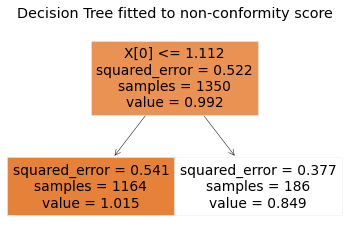

In [7]:
locart_obj.plot_locart()

In [7]:
len(locart_obj.cutoffs)

10

Testing also the uniform binning:

In [8]:
split_icp["X_calib"][0, :]

array([-1.36753879])

In [9]:
split_icp["X_calib"].shape[1]

1

In [10]:
locart_obj.uniform_binning(split_icp["X_calib"], split_icp["y_calib"])

array([2.45106695, 2.42657201, 2.27558933, 2.52104267, 2.23147685,
       2.37233151, 2.22682704, 2.28748498, 2.34649815, 2.27440635])

We see that our method seems to work and return diferent thresholds for $t(x)$. So, now we compare our approach to several other commonly used approaches. In order to do that, we define the following functions:

In [26]:
def real_coverage(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def locart_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        r[i] = np.unique(locart_model.predict_coverage(new_X, y_mat[i, :]))  
    return r

def uniform_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        r[i] = np.unique(locart_model.predict_coverage_uniform(new_X, y_mat[i, :]))  
    return r


def plot_coverage(kind = "homoscedastic", 
           n = 20000,
           d = 20, 
           coef = 2,
           hetero_value = 1, 
           random_seed = 1250, 
           sig = 0.05,
           alpha = 0.5,
           B_x = 5000,
           B_y = 1000,
           type_score = "regression",
           base_model = RandomForestRegressor,
           figname_tree = "locart_tree.pdf",
           figname_prediction = "res_pred.pdf",
           split_calib = False,
           plot_tree = True,
           plot_prediction = True,
           plot_coverage = True,
           criterion = "squared_error",
           max_depth = None,
           max_leaf_nodes = None,
           min_samples_leaf = 100,
           **kwargs):
           
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5,calibrate = False)

    # coverage plot elements
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)
        
        # computing locart coverage for each grid
        locart_real = locart_coverage(locart_obj, X_test, y_mat)

        # fitting default regression split
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(split_icp["X_train"], split_icp["y_train"])
        icp.calibrate(split_icp["X_test"], split_icp["y_test"])

        # fitting uniform binning regression split
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])
        # computing local coverage to uniform binning
        uniform_real = uniform_coverage(locart_obj, X_test, y_mat)

        # icp real coverage
        icp_r_real = real_coverage(icp.predict(X_test, significance = sig), y_mat)

        # computing average distance of coverage to 1 - alpha
        locart_ave_dist = np.mean(np.abs(locart_real - (1 - sig)))
        icp_ave_dist = np.mean(np.abs(icp_r_real - (1 - sig)))
        uniform_ave_dist = np.mean(np.abs(uniform_real - (1 - sig)))

        # computing average coverage
        locart_ave_cover = np.mean(locart_real)
        icp_ave_cover = np.mean(icp_r_real)
        uniform_ave_cover = np.mean(uniform_real)
        
        all_results = [locart_real, pd.DataFrame(data = {"Methods":["LOCART", "Regresion split", "Euclidean regression split"],
        "Average coverage":[locart_ave_cover, icp_ave_cover, uniform_ave_cover], 
        "Average distance":[locart_ave_dist,  icp_ave_dist, uniform_ave_dist]})]
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        cqr = QuantileSplit(base_model, alpha = sig, **kwargs)
        cqr.fit(split_icp["X_train"], split_icp["y_train"])
        cqr.calibrate(split_icp["X_test"], split_icp["y_test"])

        # fitting locart
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model, 
        alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # fitting euclidean binning
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])

        # computing local coverage for uniform binning
        uniform_real = uniform_coverage(locart_obj, X_test, y_mat)

        # local coverage for quantile split
        quantile_r_real = real_coverage(cqr.predict(X_test), y_mat)

        # local coverage for locart
        locart_real = locart_coverage(locart_obj, X_test, y_mat)

        # computing average distance of coverage to 1 - alpha
        locart_ave_dist = np.mean(np.abs(locart_real - (1 - sig)))
        cqr_ave_dist = np.mean(np.abs(quantile_r_real - (1 - sig)))
        uniform_ave_dist = np.mean(np.abs(uniform_real - (1 - sig)))

        # computing average coverage
        locart_ave_cover = np.mean(locart_real)
        cqr_ave_cover = np.mean(quantile_r_real)
        uniform_ave_cover = np.mean(uniform_real)
        
        all_results = [locart_real, pd.DataFrame(data = {"Methods":["LOCART", "Quantile split", "Euclidean quantile split"],
        "Average coverage":[locart_ave_cover, cqr_ave_cover, uniform_ave_cover],
        "Average distance":[locart_ave_dist, cqr_ave_dist, uniform_ave_dist]})]
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return all_results

Now, we will vary several distribution and function parameters and compare our method to the default Split conformal method:

Taking: $d = 1$, $\beta_1 = 2$, Random forest as base model, and not splitting the calibration data, we obtain the following plots and average coverage:

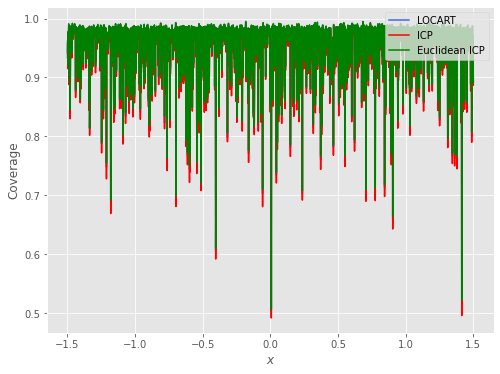

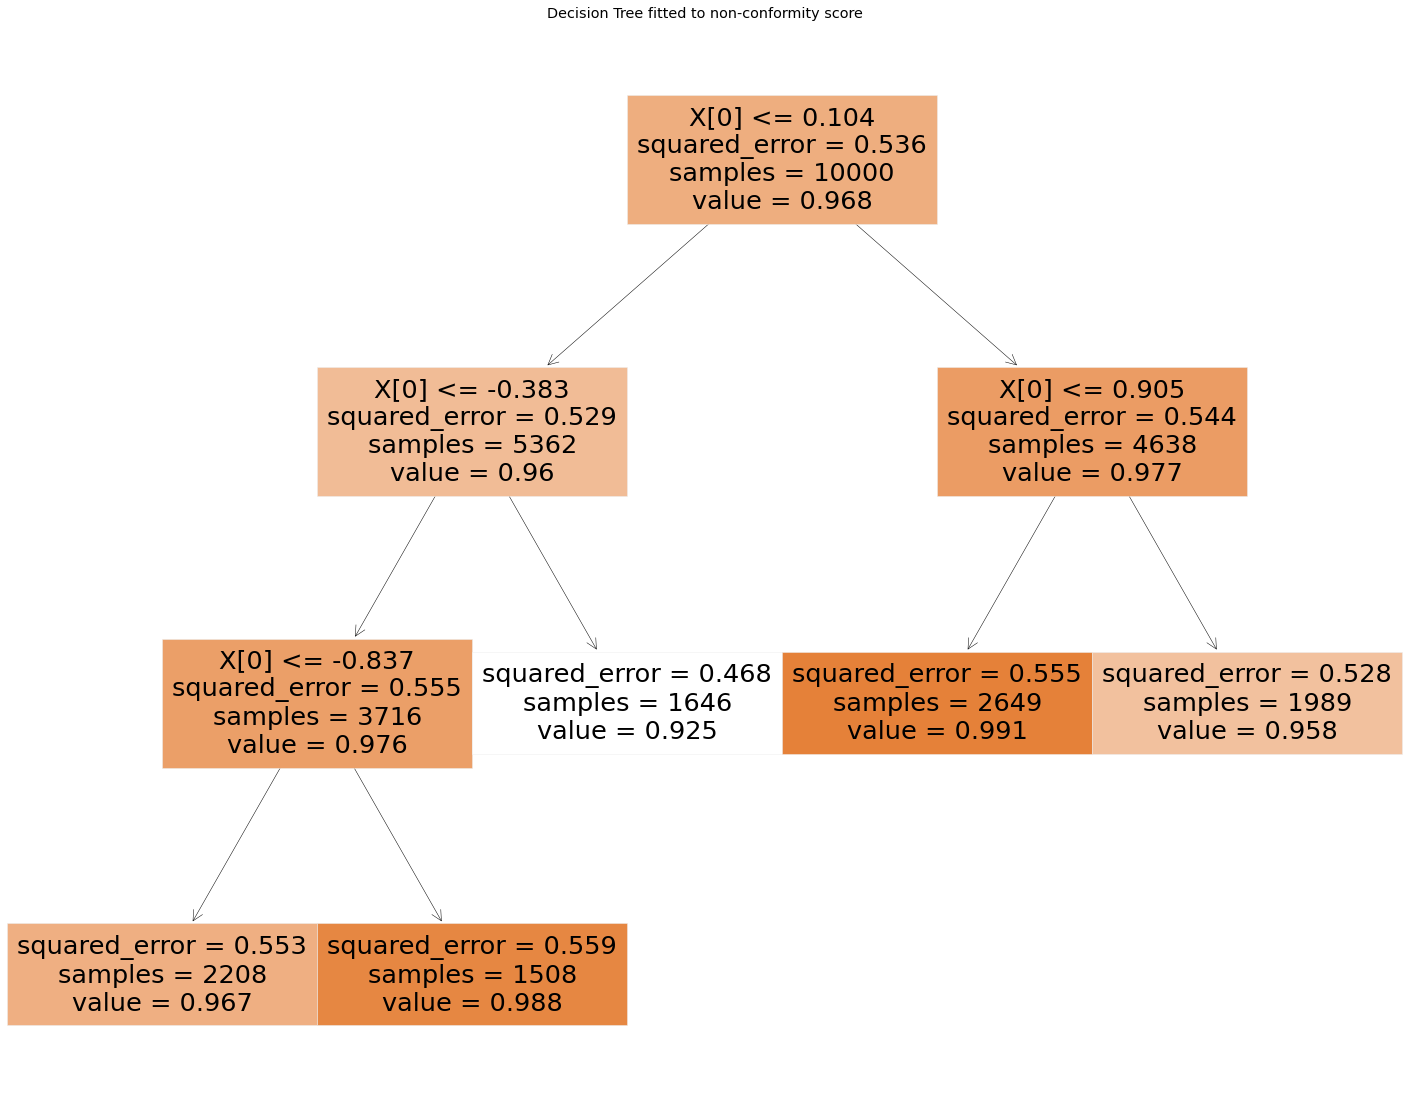

<Figure size 432x288 with 0 Axes>

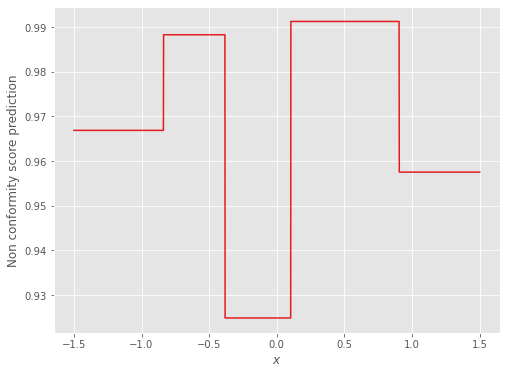

In [13]:
locart_cov_values = plot_coverage(figname_coverage = "coverage_plot_homoscedastic_reg_score_RF_d_1.pdf",
figname_tree = "locart_tree_homoscedastic_RF_d_1.pdf",B_x = 2000, d = 1, min_samples_leaf = 1500, random_state = 1250)

In [14]:
locart_cov_values[1]

,Methods,Average coverage,Average distance
0,LOCART,0.955855,0.032914
1,Regresion split,0.952026,0.032947
2,Euclidean regression split,0.957377,0.032985


Splitting calibration data:

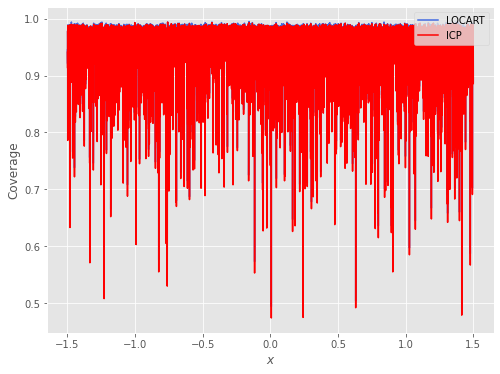

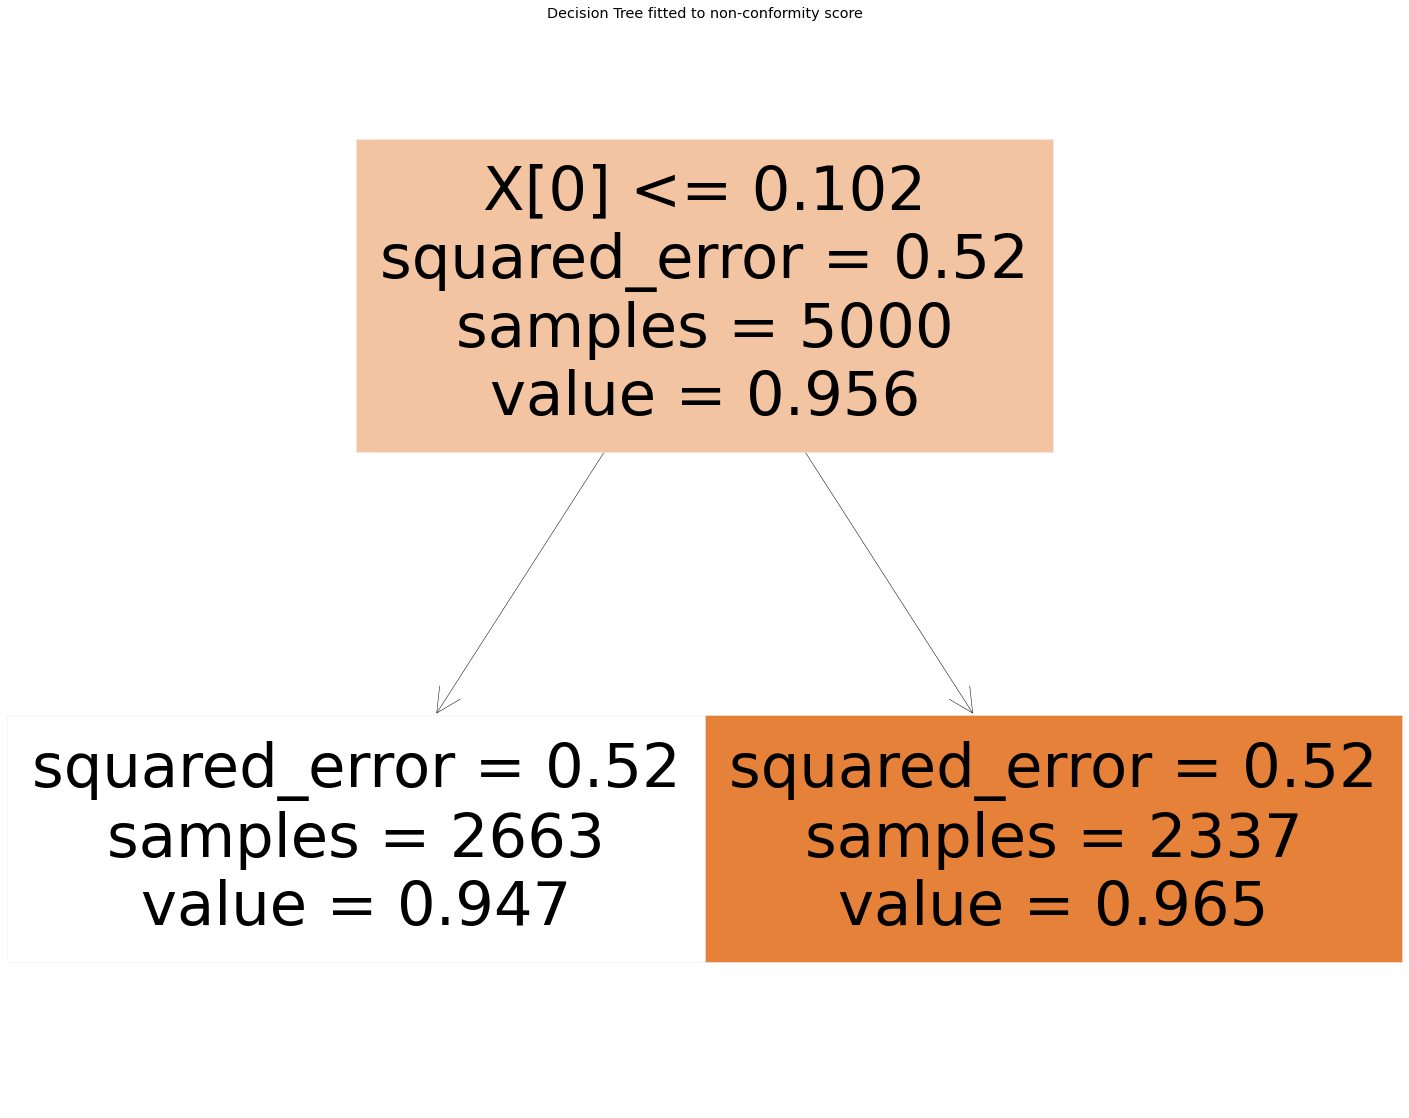

<Figure size 432x288 with 0 Axes>

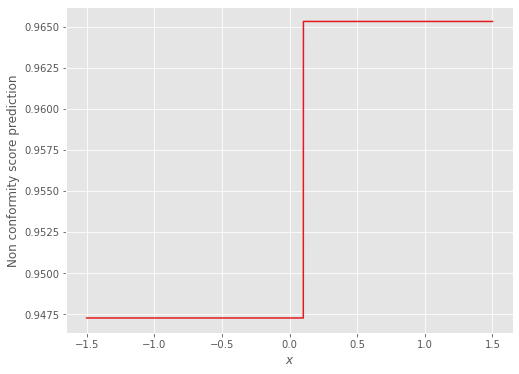

In [8]:
locart_cov_values_split = plot_coverage(figname_coverage = "coverage_plot_homoscedastic_reg_score_RF_d_1_split.pdf",
figname_tree = "locart_tree_homoscedastic_RF_d_1_split.pdf", d = 1, min_samples_leaf = 1500, split_calib = True, random_state = 1250)

Testing quantile meshgrid

In [7]:
a = np.quantile(np.array([[1, 2],
[2, 3],
[3, 4],
[5, 6],
[4, 5]]), q = np.array([0.25, 0.5, 0.75, 1]), axis = 0)

In [66]:
np.split(a.T, 1, axis = 0)

[array([[2., 3., 4., 5.]])]

In [8]:
a_split = np.split(a.T, 2, axis = 0)
b = [i.reshape(-1) for i in a_split]

In [9]:
locart_cov_values_split[1]

,Methods,Average coverage
0,LOCART,0.033429
1,Regresion split,0.033592


Checking if the coverage values from locart with and without split are all equal:

In [24]:
np.all(locart_cov_values == locart_cov_values_split)

False

Given that both vectors are not equal, we plot one versus the other now:

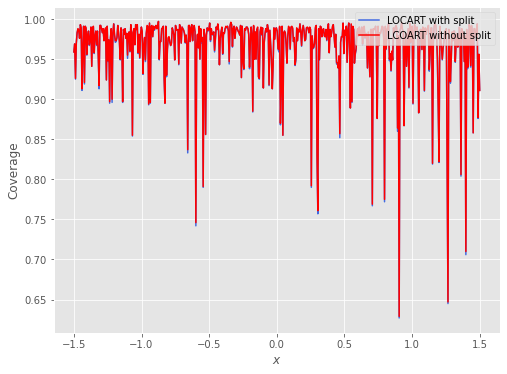

In [23]:
plt.figure(figsize = (8, 6))
# ground truth
X_grid = np.linspace(-1.5, 1.5, num = 500)
plt.plot(X_grid, locart_cov_values_split, label = "LOCART with split", color = "royalblue")
plt.plot(X_grid, locart_cov_values, label = "LCOART without split", color = "red")
plt.xlabel("$x$")
plt.ylabel("Coverage")
plt.legend(loc=1)
plt.show()

Plotting only the split LOCART values:

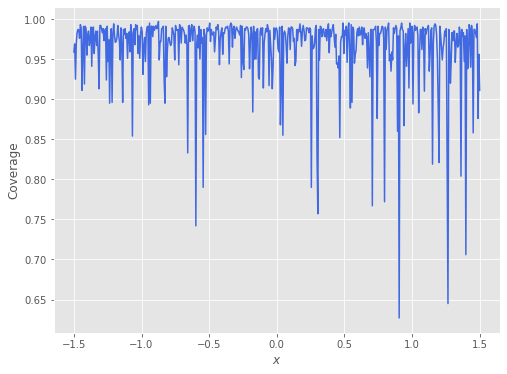

In [25]:
plt.figure(figsize = (8, 6))
# ground truth
X_grid = np.linspace(-1.5, 1.5, num = 500)
plt.plot(X_grid, locart_cov_values_split, label = "LOCART with split", color = "royalblue")
plt.xlabel("$x$")
plt.ylabel("Coverage")
plt.show()

Testing for heteroscedastic setting with $d = 1$ and $\sigma = \sqrt{\gamma + \beta_1 \cdot |X_1|}$ with $\gamma = 0.1$ and $\beta_1 = 2$

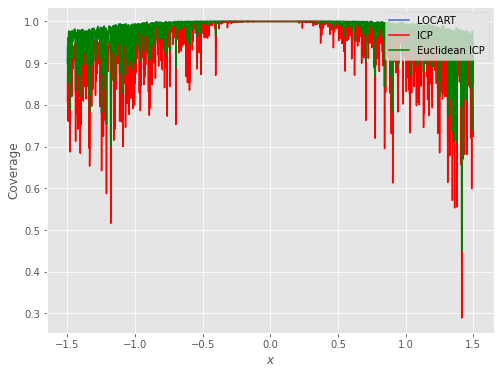

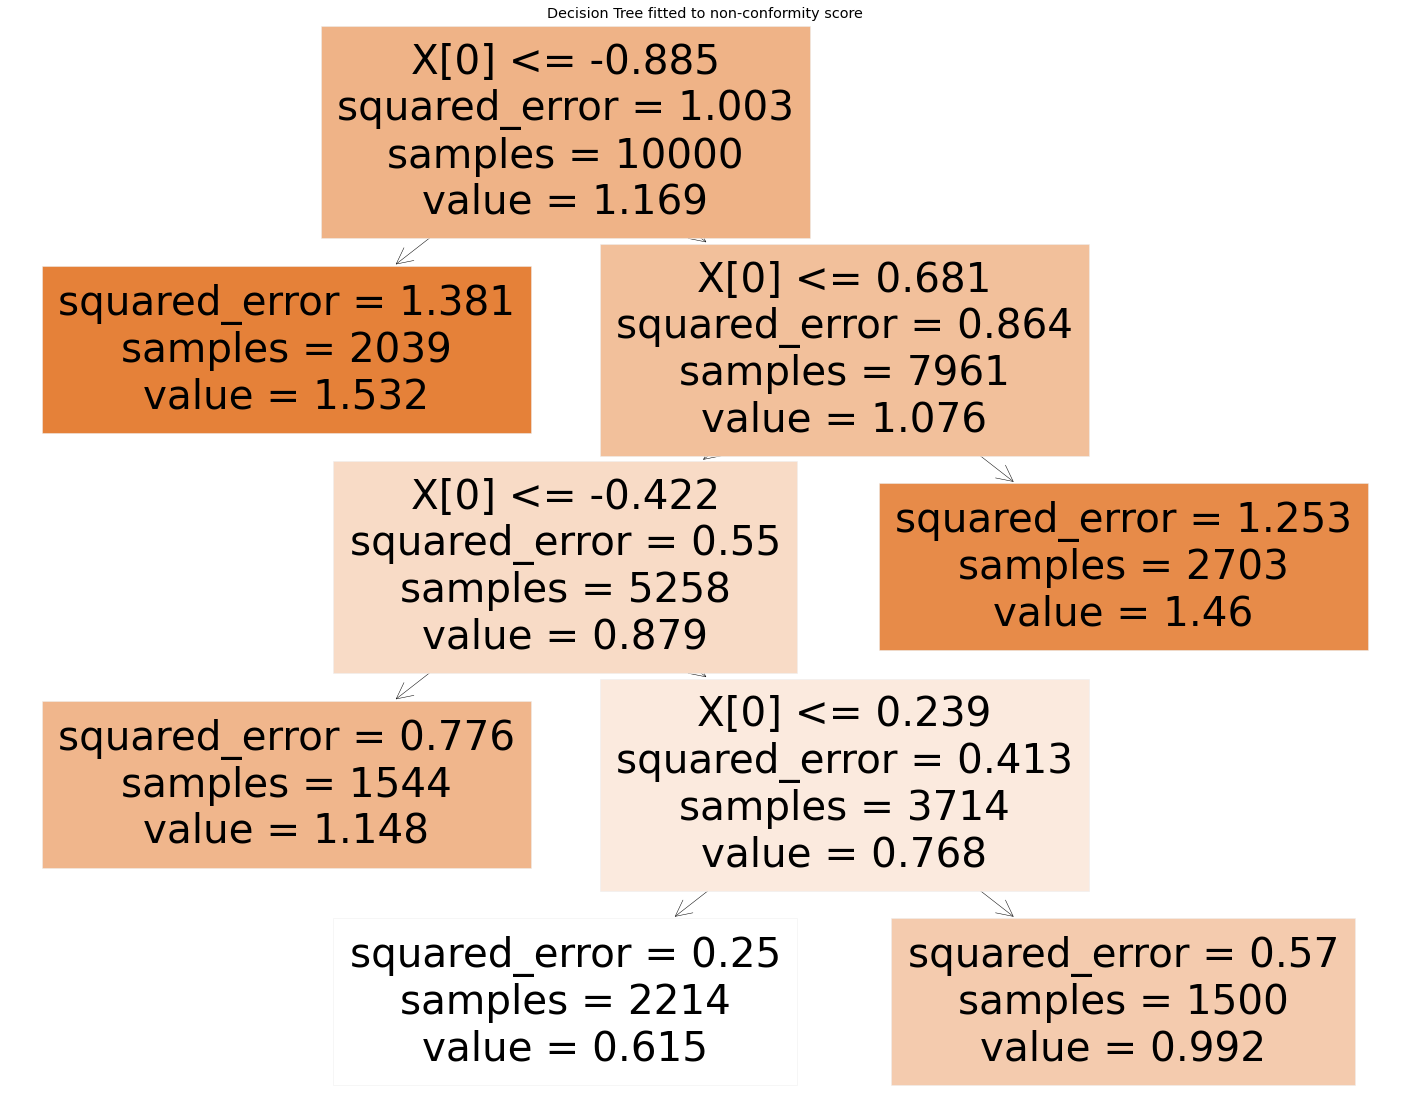

<Figure size 432x288 with 0 Axes>

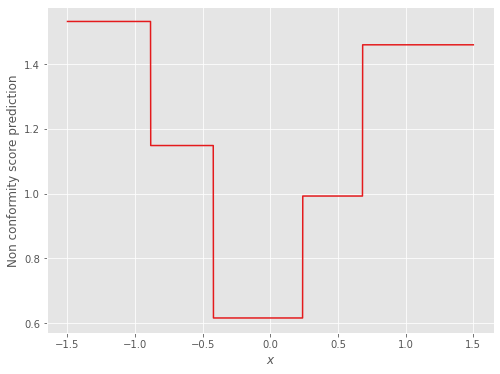

In [15]:
values = plot_coverage(kind = "heteroscedastic", d = 1, figname_coverage = "coverage_plot_heteroscdeastic_reg_score_RF_d_1_split.pdf",
figname_tree = "locart_tree_heteroscedastic_RF_d_1_split.pdf", B_x = 2000, min_samples_leaf = 1500, hetero_value = 0.1,
random_state = 1250)

In [16]:
values[1]

,Methods,Average coverage,Average distance
0,LOCART,0.980544,0.041173
1,Regresion split,0.952987,0.045704
2,Euclidean regression split,0.980693,0.041189


Increasing $d$ to 10 for both homoscedastic and heteroscedastic:

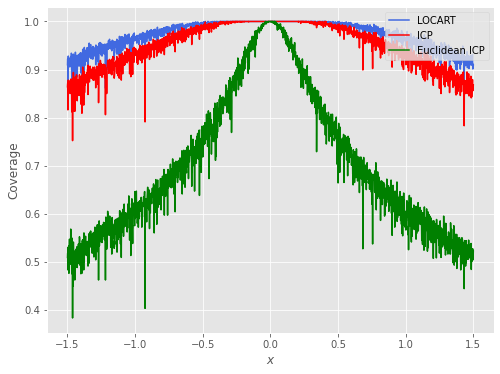

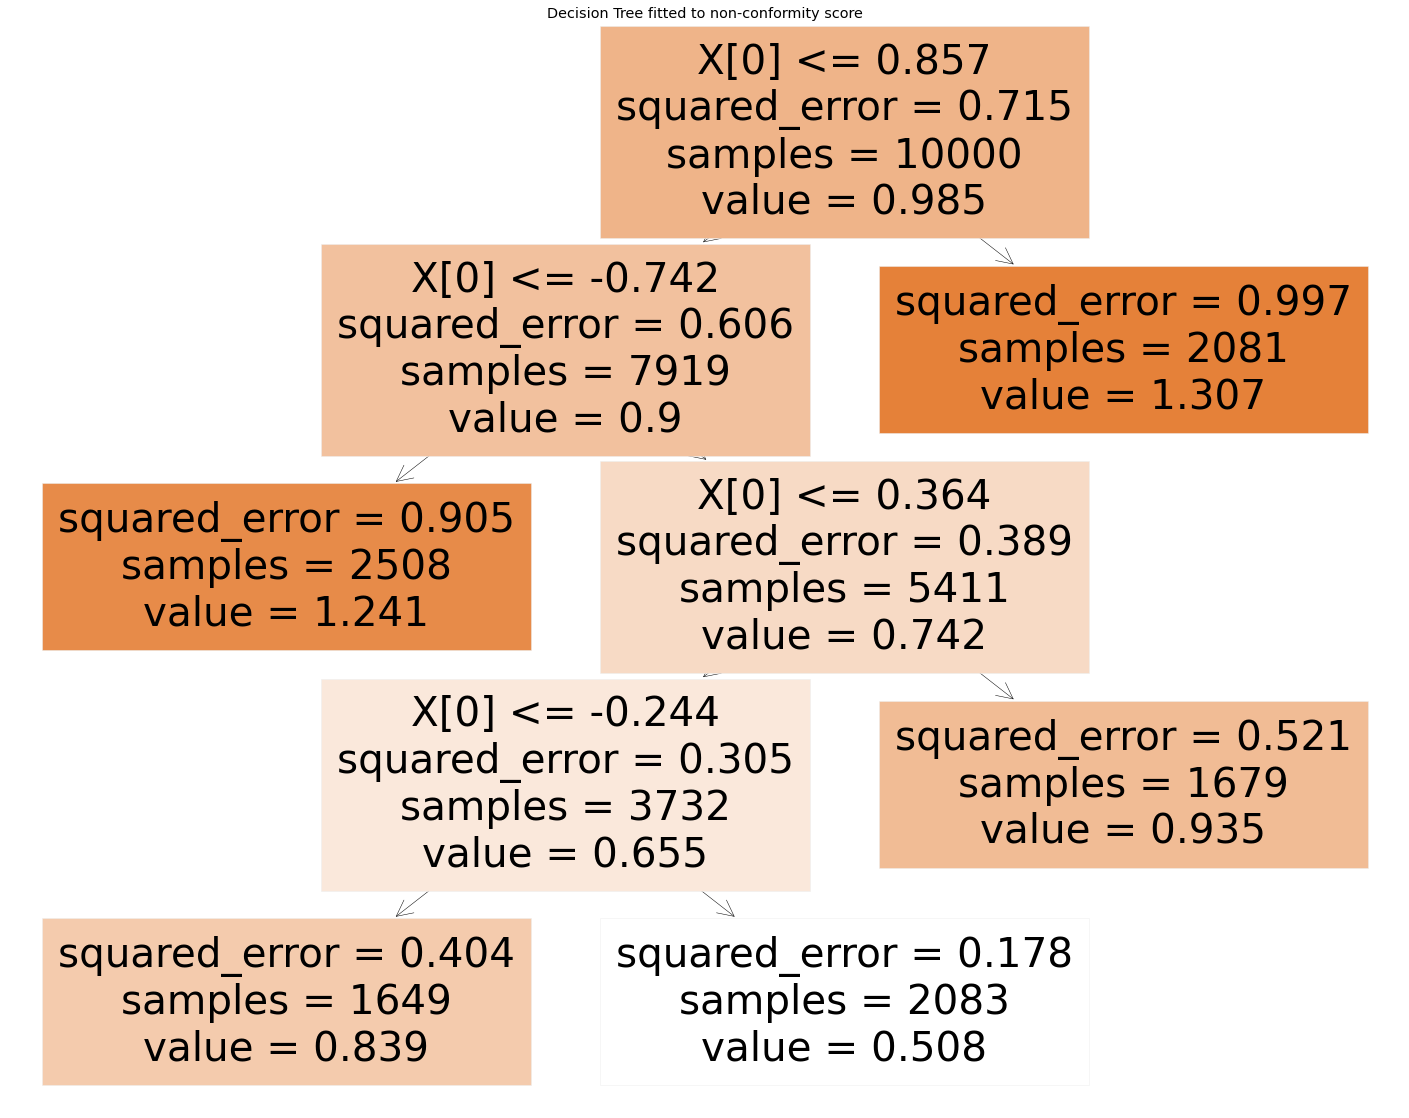

<Figure size 432x288 with 0 Axes>

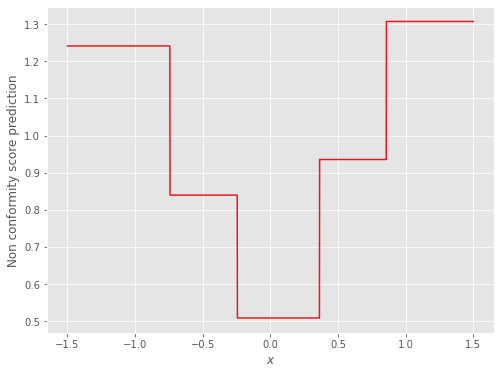

In [17]:
values = plot_coverage(kind = "heteroscedastic", d = 10, figname_coverage = "coverage_plot_heteroscdeastic_reg_score_RF_d_10.pdf",
figname_tree = "locart_tree_heteroscedastic_RF_d_10.pdf", B_x = 2000, min_samples_leaf = 1500, hetero_value = 0.1,
random_state = 1250)

In [18]:
values[1]

,Methods,Average coverage,Average distance
0,LOCART,0.973181,0.032846
1,Regresion split,0.950631,0.040341
2,Euclidean regression split,0.702913,0.253460


Homoscedastic:

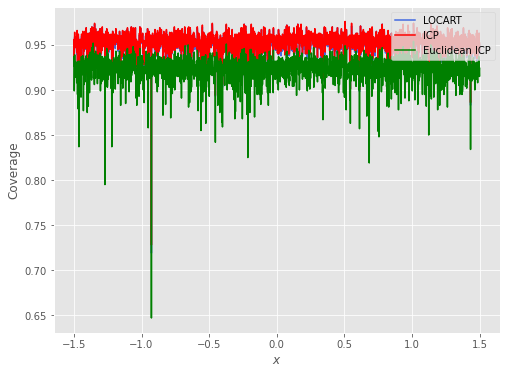

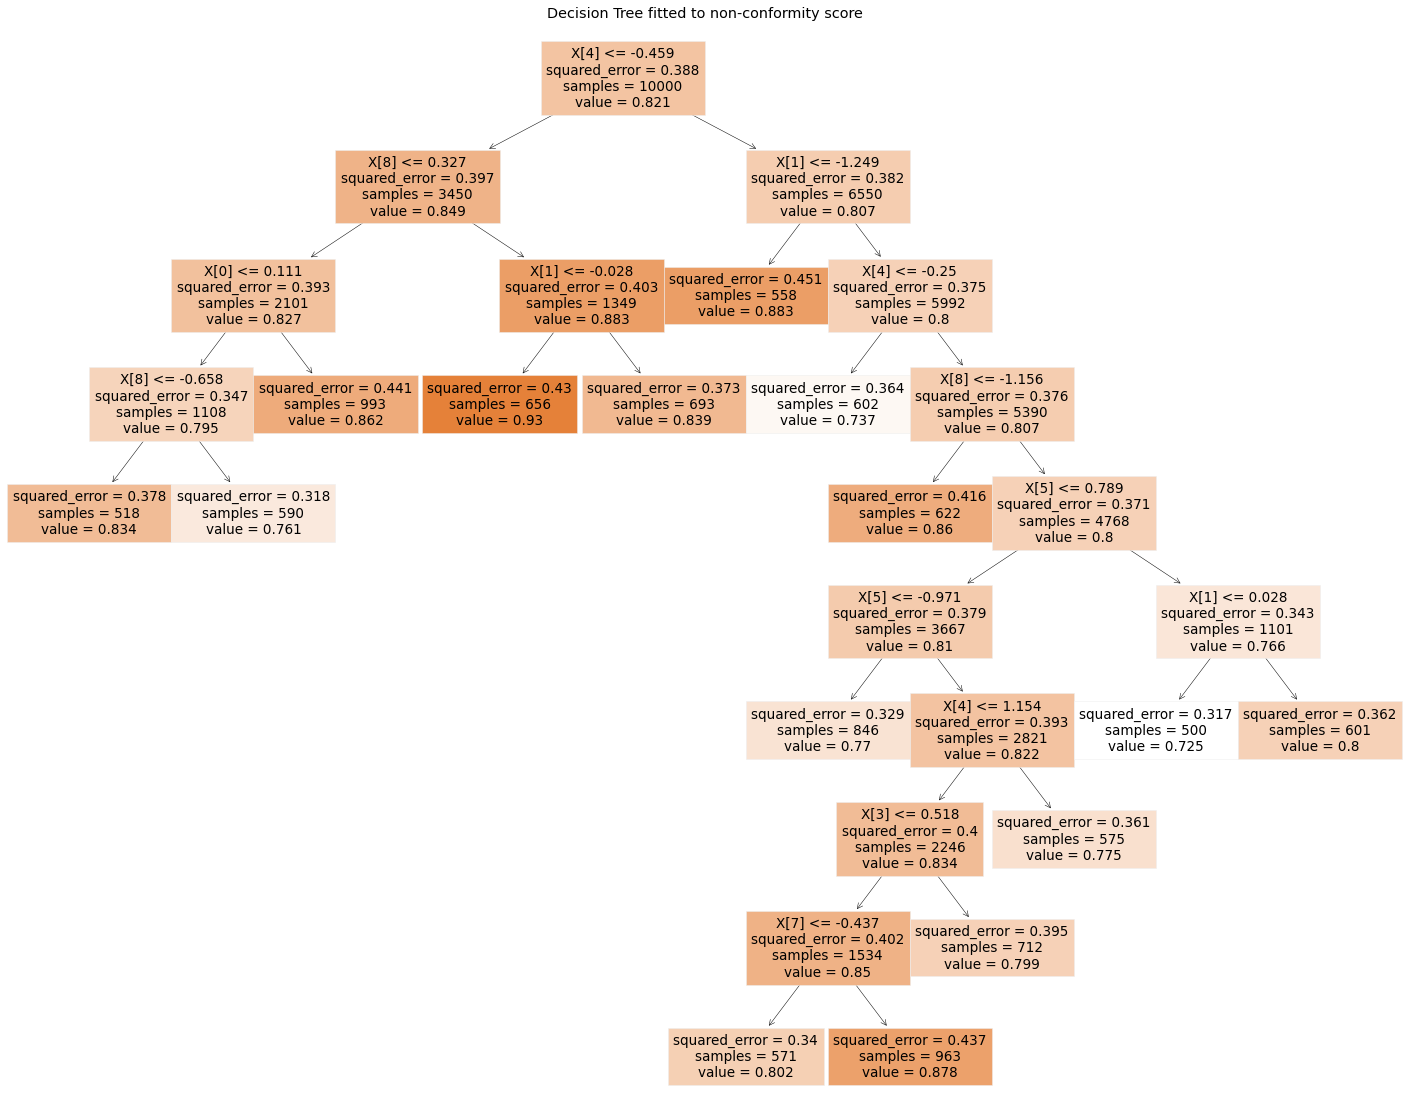

<Figure size 432x288 with 0 Axes>

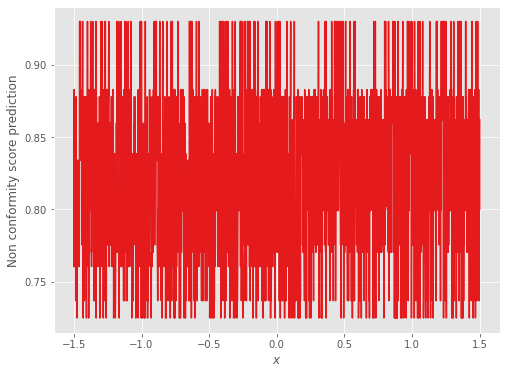

In [19]:
values_homoc_d_10 = plot_coverage(kind = "homoscedastic", d = 10, figname_coverage = "coverage_plot_homoscedastic_reg_score_RF_d_10.pdf",
figname_tree = "locart_tree_homoscedastic_RF_d_10.pdf", B_x = 2000, min_samples_leaf = 500,
random_state = 1250)

In [20]:
values_homoc_d_10[1]

,Methods,Average coverage,Average distance
0,LOCART,0.951374,0.008412
1,Regresion split,0.952598,0.008735
2,Euclidean regression split,0.922212,0.027795


Comparing now the quantile-based version of each conformal method, for both homoscedastic and heteroscedastic simulated data, first for $d = 1$:

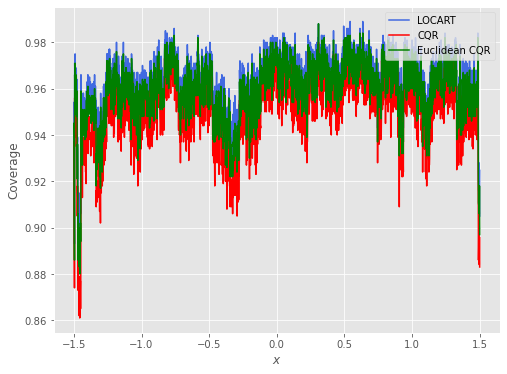

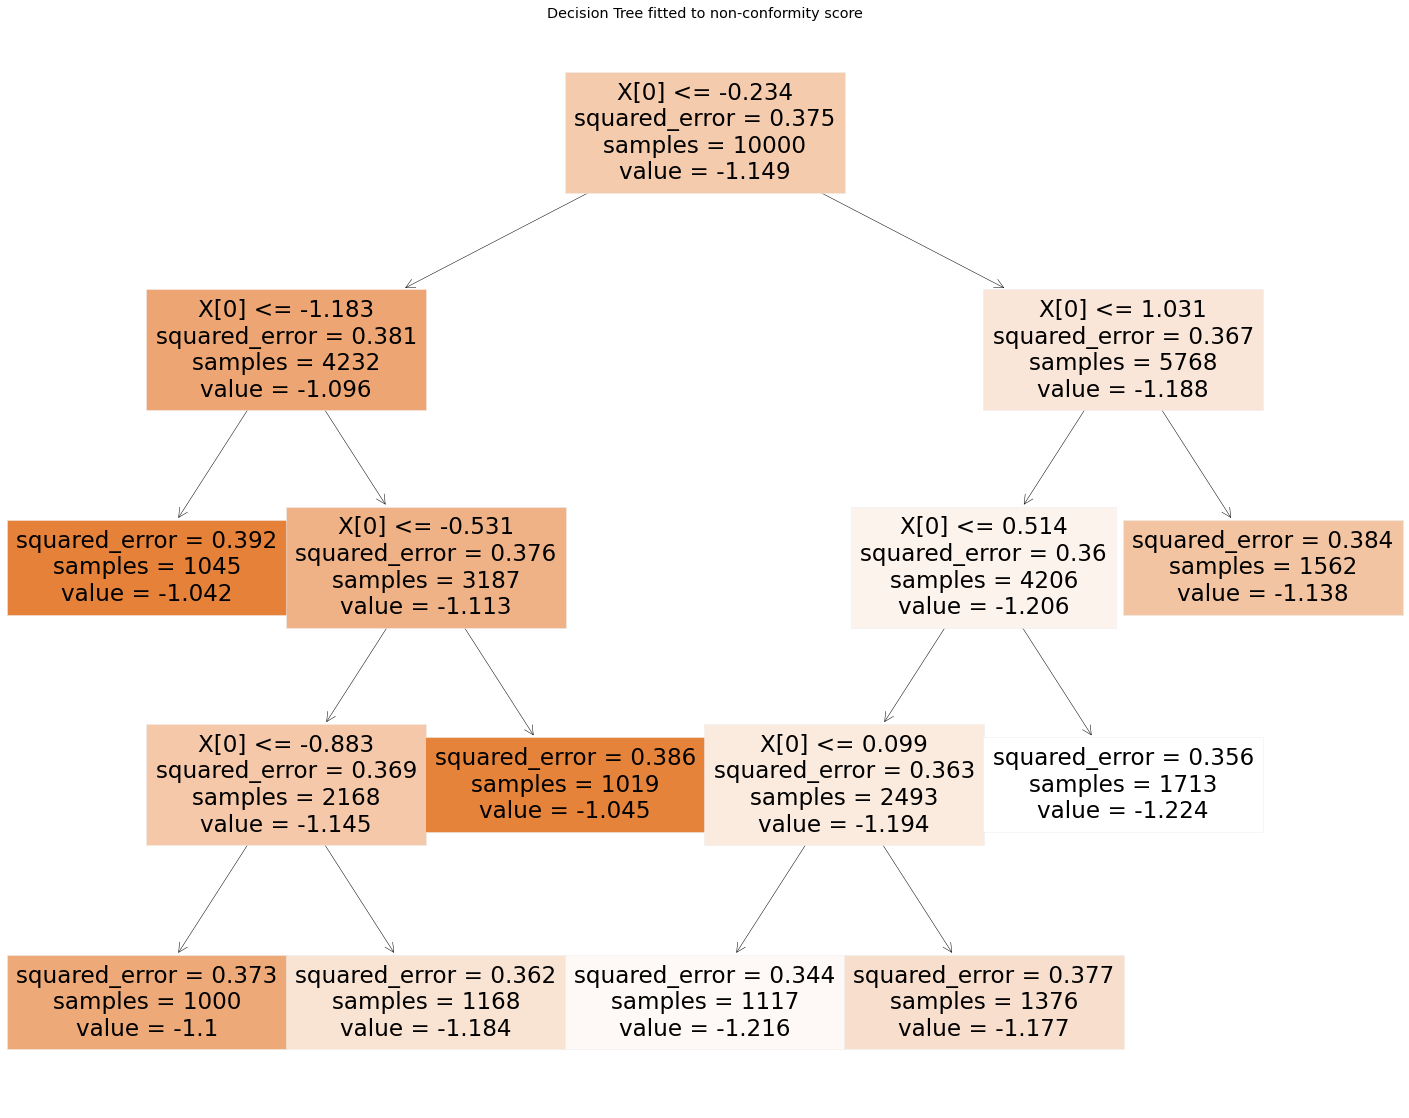

<Figure size 432x288 with 0 Axes>

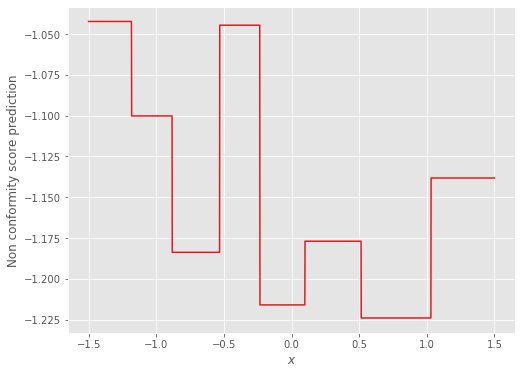

In [21]:
qvalues_homoc_d_1 = plot_coverage(kind = "homoscedastic", type_score = "quantile",
d = 1, figname_coverage = "coverage_plot_homoscedastic_q_score_GBQR_d_1.pdf", 
base_model = GradientBoostingQuantileRegression, figname_tree = "locart_tree_homoscedastic_GBQR_d_1.pdf",
B_x = 2000, min_samples_leaf = 1000, n_estimators = 200, random_state = 1250)

In [22]:
qvalues_homoc_d_1[1]

,Methods,Average coverage,Average distance
0,LOCART,0.963947,0.016152
1,Quantile split,0.949950,0.011157
2,Euclidean quantile split,0.959130,0.013352


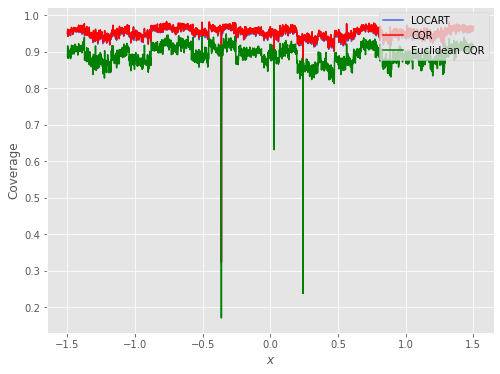

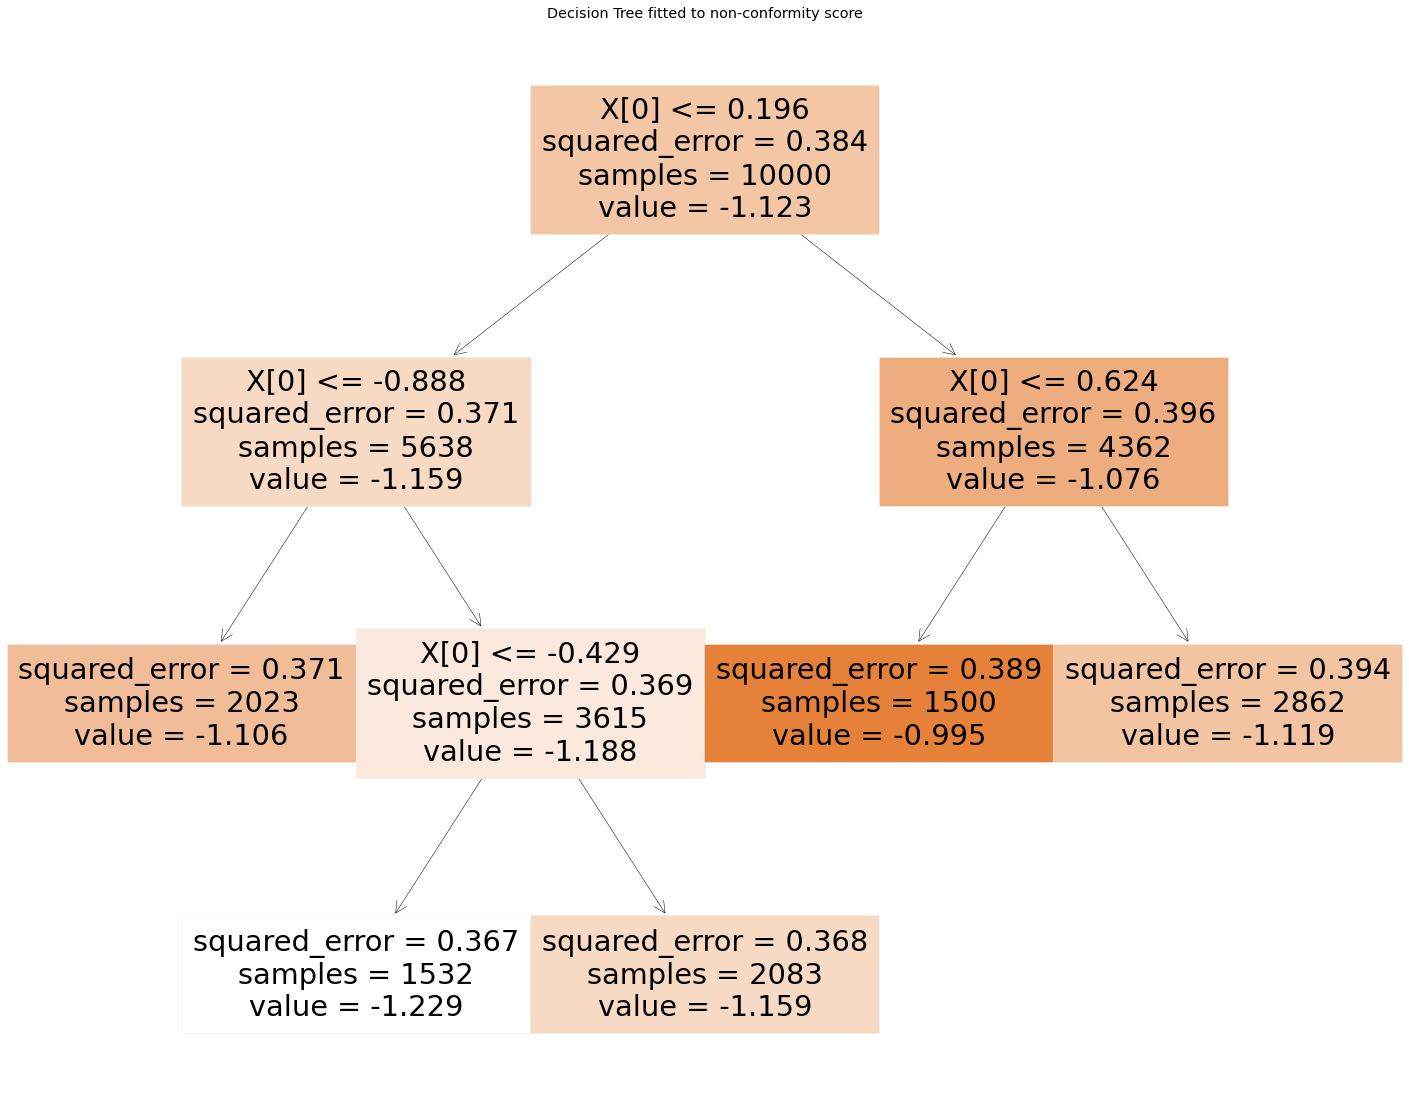

<Figure size 432x288 with 0 Axes>

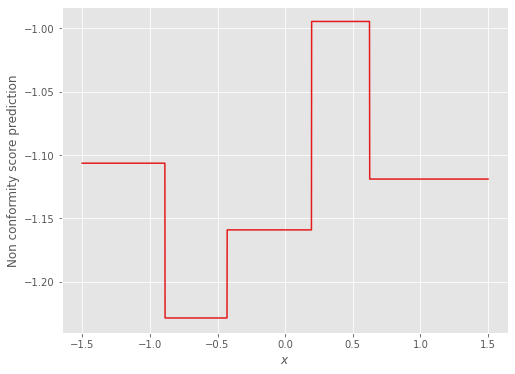

In [23]:
qvalues_homoc_d_10 = plot_coverage(kind = "homoscedastic", type_score = "quantile",
d = 10, figname_coverage = "coverage_plot_homoscedastic_q_score_GBQR_d_10.pdf", 
base_model = GradientBoostingQuantileRegression, figname_tree = "locart_tree_homoscedastic_GBQR_d_10.pdf",
B_x = 2000, min_samples_leaf = 1500, n_estimators = 200, random_state = 1250)

In [24]:
qvalues_homoc_d_10[1]

,Methods,Average coverage,Average distance
0,LOCART,0.951014,0.011302
1,Quantile split,0.952822,0.011351
2,Euclidean quantile split,0.890747,0.059252


Fixing $d = 20$:

In [27]:
qvalues_homoc_d_20 = plot_coverage(kind = "homoscedastic", type_score = "quantile",
d = 20, figname_coverage = "coverage_plot_homoscedastic_q_score_GBQR_d_30.pdf", 
base_model = GradientBoostingQuantileRegression, figname_tree = "locart_tree_homoscedastic_GBQR_d_30.pdf",
B_x = 2000, min_samples_leaf = 1500, n_estimators = 200, random_state = 1250)

KeyboardInterrupt: 

In [ ]:
qvalues_homoc_d_20[1]

For heteroscedastic:

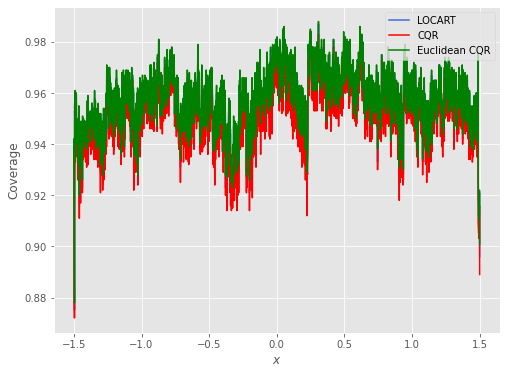

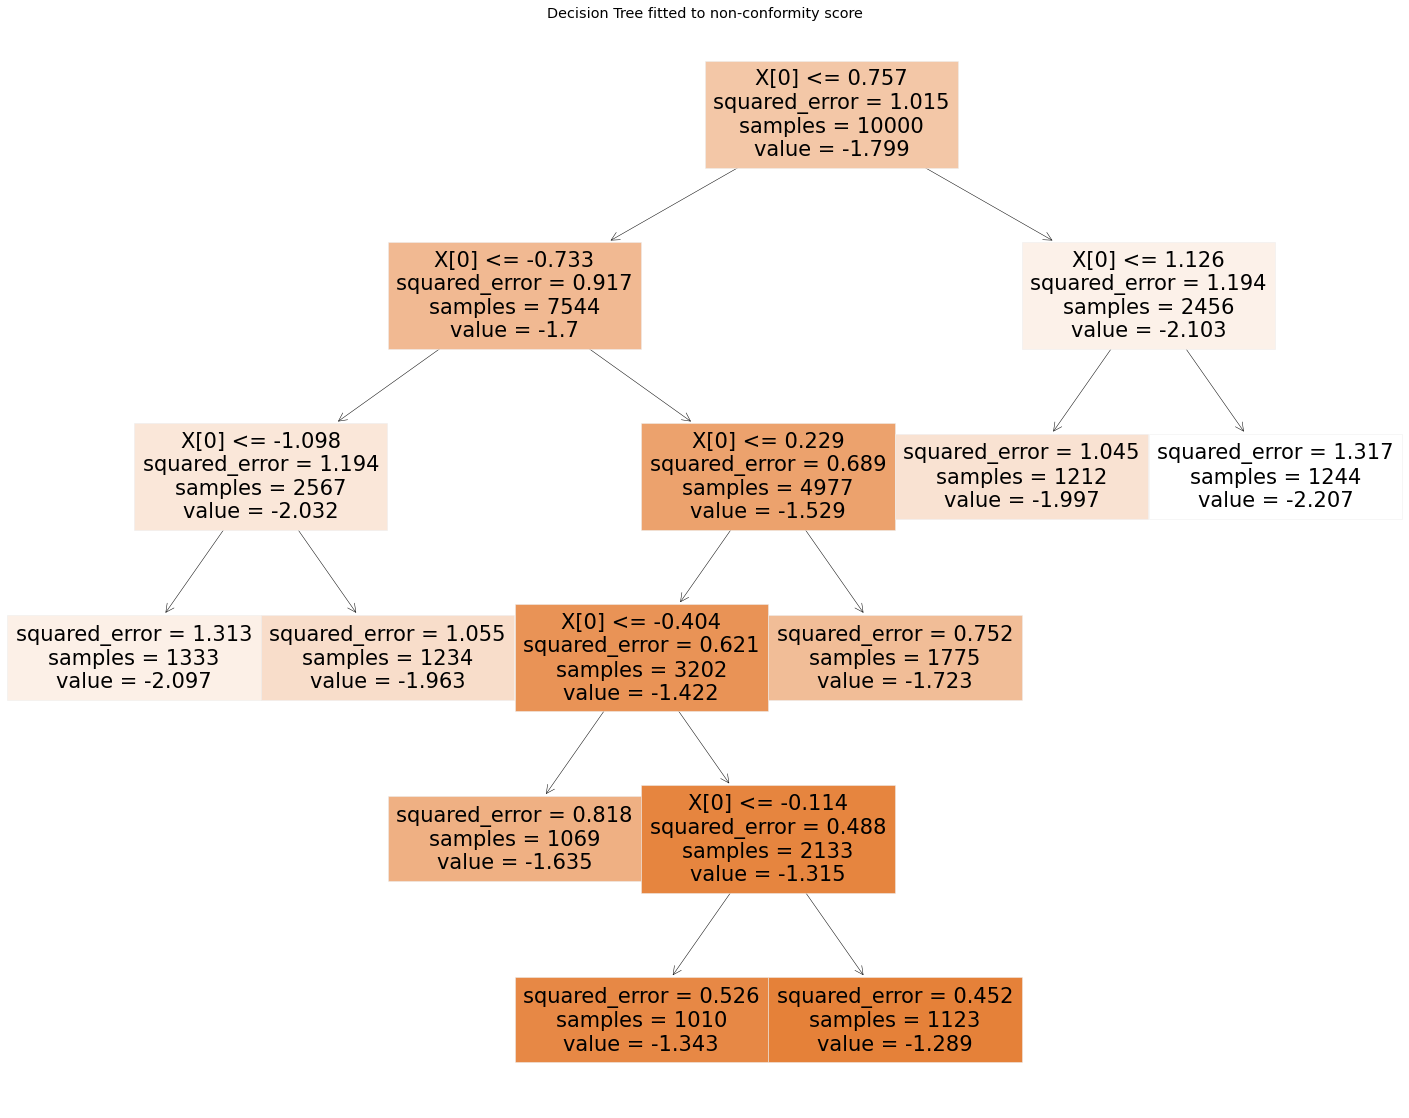

<Figure size 432x288 with 0 Axes>

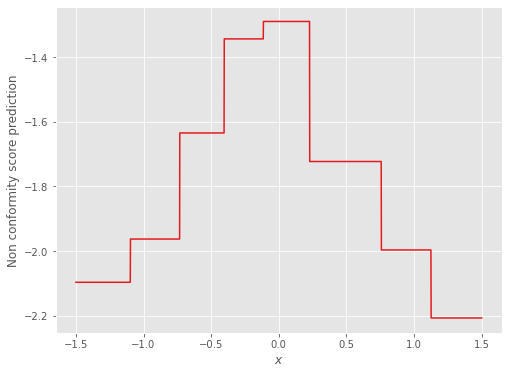

In [28]:
qvalues_hetero_d_1 = plot_coverage(kind = "heteroscedastic", type_score = "quantile",
d = 1, figname_coverage = "coverage_plot_heteroscedastic_q_score_GBQR_d_1.pdf", 
base_model = GradientBoostingQuantileRegression, figname_tree = "locart_tree_heteroscedastic_GBQR_d_1.pdf",
B_x = 2000, min_samples_leaf = 1000, n_estimators = 200, random_state = 1250)

In [29]:
qvalues_hetero_d_1[1]

,Methods,Average coverage,Average distance
0,LOCART,0.955736,0.010638
1,Quantile split,0.951448,0.009798
2,Euclidean quantile split,0.957947,0.011564


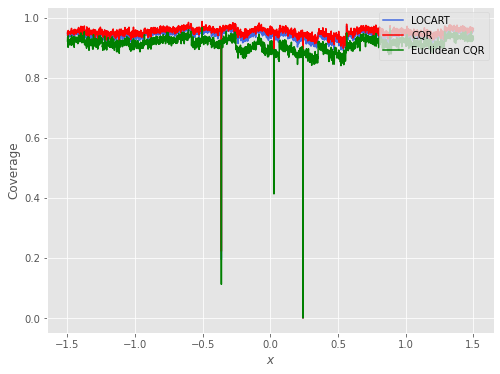

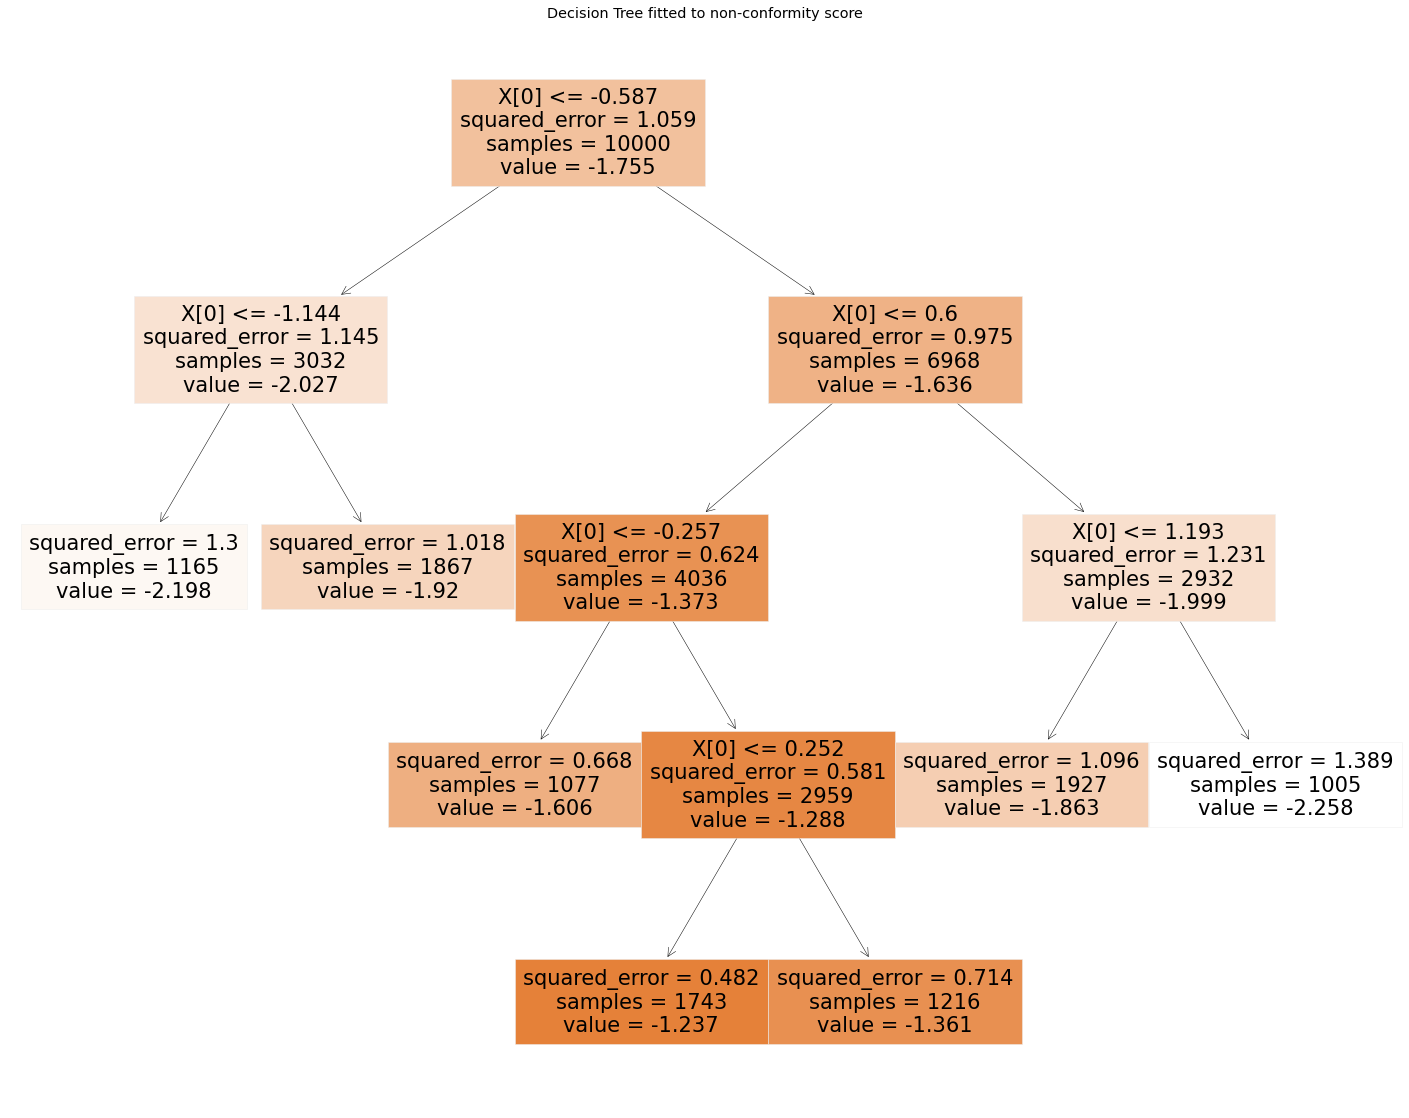

<Figure size 432x288 with 0 Axes>

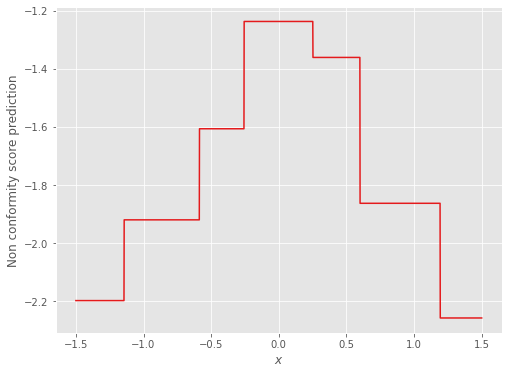

In [30]:
qvalues_hetero_d_10 = plot_coverage(kind = "heteroscedastic", type_score = "quantile",
d = 10, figname_coverage = "coverage_plot_heteroscedastic_q_score_GBQR_d_10.pdf", 
base_model = GradientBoostingQuantileRegression, figname_tree = "locart_tree_heteroscedastic_GBQR_d_10.pdf",
B_x = 2000, min_samples_leaf = 1000, n_estimators = 200, random_state = 1250)

In [31]:
qvalues_hetero_d_10[1]

,Methods,Average coverage,Average distance
0,LOCART,0.943415,0.012179
1,Quantile split,0.951536,0.010538
2,Euclidean quantile split,0.910357,0.039718


In [6]:
np.column_stack((np.array([1, 2, 3]), np.array([2, 3, 4])))

array([[1, 2],
       [2, 3],
       [3, 4]])